Authors: Fernando Díaz González and Giorgio Ruffa
{fdiaz, ruffa}@kth.se

ID 2222 Data Mining. Assignment 2

# Mining Data Streams

In [1]:
import binascii
import copy
import networkx as nx
import matplotlib.pyplot as plt
import random

from collections import defaultdict
from networkx import Graph, DiGraph

## Exact-Counter

We first implement an exact counter using python sets in order to verify the correctness of the hyperball algorithm.

In [29]:
class Counter:
    
    def __init__(self, initial=None):
        self.distincts = set() if not initial else initial
        
    def add(self, node):
        self.distincts.add(node)
        
    def value(self):
        return len(self.distincts)
    
    def union(self, other):
        return Counter(self.distincts.union(other.distincts))
        
    def __str__(self):
        return 'Counter has value {}'.format(self.value())
    
    def __repr__(self):
        return str(self.value())

In [30]:
counter = Counter()
for i in range(100):
    counter.add(i)
print(counter)

Counter has value 100


## Flajolet-Martin

The basic idea is to hash the elements of the stream to a bit-string that is sufficiently long ($log_2(N)$ where $N$ is the number of distinct elements in the stream). The more distinct values that we see, the more different hash-values we shall see, and it becomes more likely that one of this hash-values will be "unusual". This unusual property is the hash ending in many 0's.

It is clear that, given all the possible hash-values:
* $1/2$ of them end in 1 zeros.
* $1/4$ of them end in 2 zeros.

$\vdots$
* $1/2^i$ of them end in $i$ zeros.

This mean that we would need to hash $i$ different elements to see a hash ending in $i$ zeros. Then, we can approximate the number of distinct elements seen as $2^R$, where $R$ is the maximum tail length of any hash seen.

We can combine various estimates to reduce the error. By default, our counter uses 100 different hash functions which are grouped in 10 groups. We take the average (of $R$) of these groups to finally take the median of the averages as our final estimation.

In [4]:
class FMCounter:
    
    def __init__(self, n_hashing_functions=100, bit_string_length=16, n_splits=10, initial=None):
        self.Rs = [0 for _ in range(n_hashing_functions)] if not initial else initial  # following mmds
        self.n_hashing_functions = n_hashing_functions
        self.bit_string_length = bit_string_length
        self.n_splits = n_splits
        self.modulus = 2**(bit_string_length + 1) - 1
        self.coefficients_a = self._generate_coefficient_list(n_hashing_functions)
        self.coefficients_b = self._generate_coefficient_list(n_hashing_functions)
        
    def _generate_coefficient_list(self, number_of_coefficients):
        # integers in python have arbitrary precision (not applicable to numpy)
        # https://mortada.net/can-integer-operations-overflow-in-python.html
        coefficients = []
        
        def random_int():
            return random.randint(0,self.modulus - 1)
        
        for _ in range(number_of_coefficients):
            candidate = random_int()
            while candidate in coefficients:
                candidate = random_int()
            coefficients.append(candidate)
        
        return coefficients
    
    def _hash(self, node_id, a, b):
        # a != b
        to_hash = 0 
        if type(node_id) == str:
            to_hash = binascii.crc32(node_id.encode("utf-8"))
        elif type(node_id) == int:
            to_hash = node_id
        else:
            raise ValueError()
        return (to_hash * a + b ) % self.modulus
    
    def _count_trailing_zeros(self, value):
        for i in range(self.bit_string_length):
            if value & (1 << i) != 0:
                return i
        return self.bit_string_length  # 2^-self.bit_string_lenght chances of being here
            
    def add(self, node):
        for i in range(len(self.Rs)):
            a = self.coefficients_a[i]
            b = self.coefficients_b[i]
            self.Rs[i] = max(
                self._count_trailing_zeros(self._hash(node, a, b)), 
                self.Rs[i]
            )
    
    def value(self):
        # compute the average of each split
        r_in_each_split = len(self.Rs) // self.n_splits
        split_medians = []
        for i in range(self.n_splits):
            start = i*r_in_each_split
            end = start + r_in_each_split
            split_content = self.Rs[ start : min(len(self.Rs), end)]
            split_content_empirical = [2 ** x * 0.77351 for x in split_content]
            split_medians.append(
                sorted(split_content_empirical)[len(split_content_empirical)//2]
            )
        return sum(split_medians) / len(split_medians)

    def union(self, other):
        assert self.n_hashing_functions == other.n_hashing_functions
        assert self.bit_string_length == other.bit_string_length
        assert self.n_splits == other.n_splits
        Rs = [0 for i in range(len(self.Rs))]
        for i in range(len(Rs)):
            Rs[i] = max(self.Rs[i], other.Rs[i])
        return FMCounter(n_hashing_functions=self.n_hashing_functions, 
                         bit_string_length=self.bit_string_length,
                         n_splits=self.n_splits,
                         initial=Rs)
        
    def __str__(self):
        return 'FMCounter has value {}'.format(self.value())
    
    def __repr__(self):
        return str(self.value())

In [31]:
n_counters = 10
distinct_values = 2**12
fm_counters = [FMCounter(bit_string_length=13) for _ in range(n_counters)]
for i in range(distinct_values):
    for counter in fm_counters:
        counter.add(i)

error = 0
for counter in fm_counters:
    actual_value = counter.value()
    error += (distinct_values - actual_value) ** 2
    print('Expected: {}, actual: {}'.format(distinct_values, actual_value))
    print('First 10 Rs: {}'.format(counter.Rs[:10]))
print('RMSE ({} counters) = {}'.format(n_counters, (error / n_counters)**0.5))

Expected: 4096, actual: 4752.44544
First 10 Rs: [12, 12, 13, 13, 13, 13, 13, 13, 13, 12]
Expected: 4096, actual: 4118.786048
First 10 Rs: [13, 12, 13, 9, 12, 12, 13, 12, 13, 13]
Expected: 4096, actual: 5069.275136
First 10 Rs: [11, 11, 10, 12, 13, 12, 13, 12, 12, 7]
Expected: 4096, actual: 4435.615744000001
First 10 Rs: [11, 12, 13, 13, 13, 13, 10, 12, 13, 13]
Expected: 4096, actual: 4752.44544
First 10 Rs: [12, 9, 13, 12, 13, 8, 13, 13, 12, 12]
Expected: 4096, actual: 5069.275136
First 10 Rs: [12, 13, 13, 13, 12, 11, 11, 13, 12, 11]
Expected: 4096, actual: 4435.615744000001
First 10 Rs: [12, 13, 12, 11, 12, 11, 13, 13, 12, 13]
Expected: 4096, actual: 5702.934528
First 10 Rs: [13, 11, 13, 13, 13, 13, 13, 10, 12, 13]
Expected: 4096, actual: 5069.275136
First 10 Rs: [13, 13, 13, 13, 11, 12, 12, 11, 13, 12]
Expected: 4096, actual: 4118.786048
First 10 Rs: [11, 12, 12, 12, 7, 10, 12, 10, 13, 13]
RMSE (10 counters) = 807.3158858124799


## Hyperball

In [6]:
test_graph = nx.read_edgelist('test_graph.edgelist', create_using=DiGraph, edgetype=str)
florida_graph = nx.read_weighted_edgelist('florida-ecosystem-dry.edgelist',
                                          comments='%', create_using=DiGraph)
# air_graph = nx.read_edgelist('air-traffic-control.edgelist', 
#                              comments='%', create_using=DiGraph)

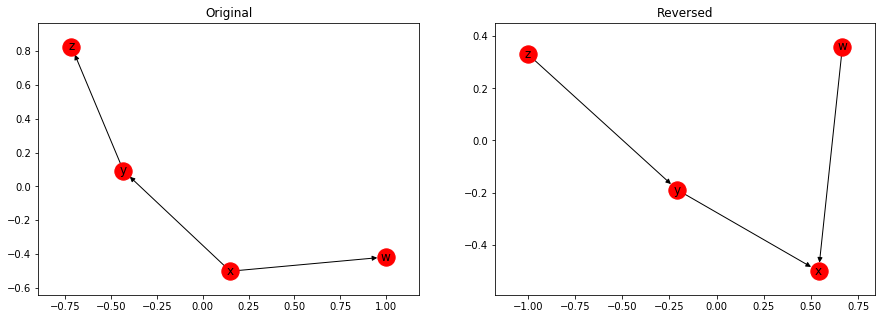

In [8]:
f = plt.figure(figsize=(15, 5))
ax = f.add_subplot(121)
nx.draw_networkx(test_graph)
plt.title('Original')
ax2 = f.add_subplot(122)
nx.draw_networkx(test_graph.reverse())
plt.title('Reversed')
plt.show()

### Why reverting the graph

The nodes _coreachable_ from $x$ are the nodes $y$ such that $d(y,x) < \infty$ (i.e., nodes from which is possible to travel to $x$). On the other hand we define the ball of radius $r$ around $x$ as:

$$
\mathscr{B}_G(x,r) = \{y|d(x,y) \le r\}
$$

For example, in the previous graph (original), the coreachable nodes from $z$ are $\{x, y\}$. If we invert the graph, the $\mathscr{B}_G(z,r) = \{x, y\}$ when $r$ is large enough.

This measure (coreachables nodes) is usefull to compute some centrality measures, such as the _harmonic closeness_.  

### Streaming implementation

To comply with the assignment's requirements, we implemented the Hyperball in a streaming fashion where the edges are ingested sequentially. Note that in order for the algorithm to work, we need sequential complete iterations over all the edges of the graph.

In [9]:
def graph_stream(graph):
    for edge in graph.edges:
        x, y = edge
        yield x, y

### Algorithm

Basic idea:

$$
\begin{align*}
\mathscr{B}_G(x,0) &= \{x\}\\
\mathscr{B}_G(x,r + 1) &= \bigcup_{x \rightarrow y} \mathscr{B}_G(y,r) \cup \{x\}
\end{align*}
$$

This is, the ball of radius $r$ around $x$ is the union of the balls of radius $r-1$ around the closest neighbors and $x$ itselft (to take into account the directionality of the graph).

Hyperball starts computing the balls of radius 0 around each one of the nodes. Then, in an iterative manner, computes the nodes contained in a ball of radius $t$ around $v$, doing the union of the nodes contained in the balls of radius $t-1$ centered on the neighbors of $v$.

For this reason we need to support the union operation between counters.

### Centralities

We can rewrite the _peripherality_ of node $x$ in terms of balls as follows: 

$$
\begin{align*}
\sum_{y} d(y,x) &= \sum_{t>0} t | \{y|d(y,x)=t\} |\\
&= \sum_{t>0} t \left( |\mathscr{B}_{G^T}(x,t)| - |\mathscr{B}_{G^T}(x,t-1)| \right)
\end{align*}
$$

For a given $t$, $\{y|d(y,x)=t\}$ are the nodes at distance $t$ from $x$. 

$t|\{y|d(y,x)=t\}|$ is the sum of their distances.

$\sum_{t>0} t |\{y|d(y,x)=t\}|$ is the sum over all the spheres of increasing radius.


Similarly, we can define the _harmonic centrality_ as follows:

$$
\begin{align*}
\sum_{y \ne x} \frac{1}{d(y,x)} &= \sum_{t>0} \frac{1}{t} | \{y|d(y,x)=t\} |\\
&= \sum_{t>0} \frac{1}{t} \left( |\mathscr{B}_{G^T}(x,t)| - |\mathscr{B}_{G^T}(x,t-1)| \right)
\end{align*}
$$

The harmonic centrality has the feature of automatically dealing with unconected components, and is considered to yield a better ranking for central nodes.

In [10]:
def hyperball(graph, counter_type=Counter):
    
    # c is an array if counters for each vertex
    c = defaultdict(counter_type)
    harmonic_closeness = defaultdict(float)
    
    # balls of radius 0 around each vertex
    for v in graph.nodes:
        c[v].add(v)

    t = 0
    while True:
        counter_changed = False
        # c is updated asynchronously so we need to keep a copy of the old counters
        # in order to correctly compute the unions
        c_old = copy.deepcopy(c)
        for v, w in graph_stream(graph):
            # a is the current updated version of the counter of the vertex
            a = c[v]
            # we need to combine with the previous of the counter to avoid leaking
            # partial results because the edges are not granted to be processed in order
            new_counter = a.union(c_old[w])
            # check if counters stabilize
            counter_changed |= new_counter.value() != a.value()
            c[v] = new_counter
        # At this point, we are sure that all the edges have been processed and we can
        # update the armonic closeness. Only once per vertex
        for v in c.keys():
            harmonic_closeness[v] += (c[v].value() - c_old[v].value()) / (t + 1)
        t += 1
        if not counter_changed:
            break
            
    return c, harmonic_closeness, t

In [11]:
def actual_harmonic_closeness(graph):
    actual_harmonic = {node: 0.0 for node in graph.nodes}
    for x in nx.nodes(graph):
        for y in nx.nodes(graph):
            if x != y:
                try:
                    sp = nx.shortest_path(graph, y, x)
                    sp = float(len(sp) - 1)
                    actual_harmonic[x] += 1 / sp
                except:
                    # Never ever do this
                    pass
    return actual_harmonic

In order to verify the correctness of the algorithm we compare the results with a "brute force" implementation of the harmonic closeness that uses the standard definition with complexity $O(n^2)$.

To avoid probability fluctuations, we use a naive set counter. 

In [32]:
h_counters, h_harmonic, h_t = hyperball(florida_graph.reverse(), counter_type=Counter)
harmonic = actual_harmonic_closeness(florida_graph)

In [33]:
def root_mean_squared_error(dict1, dict2):
    assert len(dict1) == len(dict2)
    m = len(dict1)
    error = 0
    for k, v in dict1.items():
        error += abs(v - dict2[k])**2
    return (error / m) ** 0.5

In [34]:
print('RMSE is {:.6f}'.format(root_mean_squared_error(h_harmonic, harmonic)))

RMSE is 0.000000


Now, we execute the same algorithm but using Flajolet-Martin counters.

In [35]:
h_counters_fm, h_harmonic_fm, h_t_fm = hyperball(florida_graph.reverse(), counter_type=FMCounter)

In [36]:
print('RMSE is {:.6f}'.format(root_mean_squared_error(h_harmonic_fm, harmonic)))

RMSE is 10.280194


## Extra Points

**1. What were the challenges you have faced when implementing the algorithm?**

The main challenge was dealing correcly with the update of the counters. Meaning that the union must always be computed between the updated version of the current node counter and the old version of the neighbor counter. We need to keep a complete copy of the previous counters while updating the new ones, hence occupying twice the memory. The original algorith from Boldi and Vigna stores the temporary counters on disk and update them at the end of the full iteration.

**2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.**

The algorithm is keen to parallelization. To illustrate this statetement let's think of a vertex-centric pregel-like framework where we have a step composed by a messaging part first and a computation part second.

In the messaging phase, the vertex will send his counter to each neighbour. If a probabilistic counter is used (i.e. FM or HyperLogLog counters) the amount of data exchanged is very low. In the computational part, the vertex will do the union of his counter with all the received counters.
In order for this approach to be successfull, the counters must support the union operation, as FM and HyperLogLog do.
Remember that the graph must be inverted first.

**3. Does the algorithm work for unbounded graph streams? Explain.**

No, it does not. As it is necessary for the algorithm to iterate once over all edges in order to propagate correctly the counters and construct the balls of size _t_. We proposed a slight variation of the algorithm which is able to cope with streaming edges, which enables the graph to be processed with sequential I/O. Nevertheless it is still necessary to do multiple passes over the graph and the algorithm must be notified that all the edges have been processed in order to update correctly the nodes. Remember that the measure of centrality depends on the count of element inside the ball of size $t$ and $t-1$, hence we must be sure that all the nodes are inside the ball, so all edges have been processed.

On the other hand the algorithm can cope with sporadical addition of edges, in the sense that few edges can be added while the computation is still running. For example, let's assume that the computation has reached iteration $t=4$, if an edge is added, we would have to propagate the counter of the node pointed by the edge to all vertexes in the ball of size 4. This must be done before the iteration for $t=5$ starts. This may seems pheasible for this example, but if the diameter of the graph is low, or if $t$ is big enough (i.e. we have allready converged), the nodes inside the ball can be all the nodes in the graph and recomputation can be very expensive!

Note that HyperBall was presented by the authors as an algorithm specifically designed to process large static graphs in memory. That is, storing the counters in memory, and processing the graph stored on disk with sequential I/0.

**4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.**

No, for the same reasons explained in question 3. The algorithm needs to know that all the edges have been processed in order to compute the centrality measure. 

In contrast to edge addition, edge deletion is much trickier. Firt of all we need a counter that supports item subraction, both FM and HyperLogLog does not, because we lose the memory of the history of the coin-tosses and just save the number of adiacent zeros. We do not know which item was responsible for that sequence of zeros, even if we knew and the item we are subtracting was responsible for that last value, we should still remember the history of all previous values (for subsequent edge deletions).

But let's assume that a counter that supports subtraction exists, for example by using the exact counter proposed at the beginning of the notebook which uses the complete sets. Let's also assume that the last complete computational step before the deletion was step $t$. Now, very naively, if the vertex $v$ is disconnected by the graph, we should remove all the vertexes contained in his counter to all counters contained in the ball of center $v$ and radius $t$ :  $\mathscr{B}_{G}(v,t)$. But this approach is incorrect, because the items we are trying to subtract from neighbours counters, may have reached that particular counter following other possible paths. A simple solution for this would be a _"reference counting approach"_, where each vertex contained in the counter is associated to an incremental number which increases every time the vertex is received from a neighborg counter. In this way the vertex will be removed only if the counter reaches zero.

Adapting the algorithm to edge deletion will cost a lot of memory, which will defy the goal of the original HyperBall algorithm.
